# The second experiment: use the cifar dataset to evaluate the trade-off power of different algorithms.

In [63]:
%load_ext autoreload
%autoreload 2
from lib.reduction_algorithms import EGDIS, POP, CL, WCL
from lib.callbacks import MonitorAndSaveParameters
from lib.data_loader import load_cifar10, load_cifar100
from keras.utils import to_categorical
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# init all four data reduction algorithms.
egdis = EGDIS()
pop = POP()
# CL needs the information about the dataset.
cl = CL()
wcl = WCL()

In [30]:
def show_tsne(x, y, classes):

#     return y
    tsne = TSNE(n_components=2, random_state=0, n_jobs=-1, n_iter=1500)
    intermediates_tsne = tsne.fit_transform(x)

    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        x=intermediates_tsne[:,0], y=intermediates_tsne[:,1],
        hue=y,
        palette=sns.color_palette("hls", classes),
        legend=None,
        alpha=0.3
    )
#     sns.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], hue=y)
    plt.show()
    
    return intermediates_tsne

In [39]:
def run_pop(x_train, y_train, classes, tsne):
    print("Now try to run the algorithm POP")
    sample_weakness = pop.fit(x_train, y_train)
    ax = sns.distplot(sample_weakness, kde=False, rug=True);
    ax.set_title("The distribution of the weakness")
    plt.show()
    print("------------------ Start to select subsets ------------------")
    subsets = []
    for i in range(1, int(sample_weakness.max()+1)):
        subset_idx = sample_weakness <= i
        plot_y = y_train.copy()
        plot_y[subset_idx] = classes
        ax = sns.scatterplot(tsne[:,0], tsne[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", len(np.unique(plot_y))))
        ax.set_title("Selected samples with the POP algorithm with weakness <= {}".format(i))
        plt.show()
        subsets.append(subset_idx)
    return subsets

In [44]:
def run_egdis(x_train, y_train, classes, tsne):
    print("Now try to run the algorithm EGDIS with CIFAR.")
    selected_egdis_idx = egdis.fit(x_train, y_train)
    print("Selected {} samples".format(len(selected_egdis_idx)))
    plot_y = y_train.copy()
    plot_y[selected_egdis_idx] = classes
    ax = sns.scatterplot(tsne[:,0], tsne[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", len(np.unique(plot_y))))
    ax.set_title("Samples selected by the EGDIS algorithm")
    plt.show()

    return selected_egdis_idx

In [71]:
def run_cl(x_train, y_train, classes, tsne):
    print("Now try to run the algorithm CL with CIFAR")
    cl.fit_dataset(classes=10, dataset="cifar10")
    rank, scores = cl.fit(x_train, to_categorical(y_train, num_classes=classes))
    selected_list = []
    for i in range(1, 10, 2):
        percent = i / 10.
        selected_data_idx = np.random.choice(len(y_train), int(percent * len(y_train)), replace=False, p=scores / scores.sum())
        selected_x = x_train[selected_data_idx]
        selected_y = y_train[selected_data_idx]
        print("------------------ Start to select subsets ------------------")
        print("Selected {} percent training data.".format(i*10))
        
        plot_y = y_train.copy()
        plot_y[selected_data_idx] = classes
        ax = sns.scatterplot(tsne[:,0], tsne[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", len(np.unique(plot_y))))
        
        ax.set_title("{} percent Samples selected by the CL algorithm".format(i*10))
        plt.show()
        selected_list.append(selected_data_idx)
    return selected_list, scores

In [77]:
def run_wcl(x_train, y_train, classes, tsne):
    print("Now try to run the WCL algorithm CL with CIFAR")
    wcl.fit_dataset(classes=10, dataset="cifar10")
    scores, selected_boundary_idx = wcl.fit(x_train, y_train, classes)
    print("Selected {} boundary instances.".format(len(selected_boundary_idx)))
    plot_y = y_train.copy()
    plot_y[selected_boundary_idx] = classes
    ax = sns.scatterplot(tsne[:,0], tsne[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", len(np.unique(plot_y))))
    ax.set_title("Selected {} boundary samples with EDGIS".format(len(selected_boundary_idx)))
    plt.show()
    
    for i in range(1, 10, 2):
        percent = i / 10.
        selected_data_idx = np.random.choice(len(y_train), int(percent * len(y_train)), replace=False, p=scores / scores.sum())
        print("Select {:.2f} percent samples, {} overlapping with the pre-selected boundary samples".format(percent*100, len(np.intersect1d(selected_boundary_idx, selected_data_idx)))) 
    return scores, selected_boundary_idx

In [17]:
# load the compressed dataset
cifar10 = pd.read_csv(os.path.join("datasets", "cifar10", "compressed_train.csv")).values
cifar10_x = cifar10[:,:-10]
cifar10_y = cifar10[:,-10:]
cifar10_y = np.argmax(cifar10_y, axis=1)

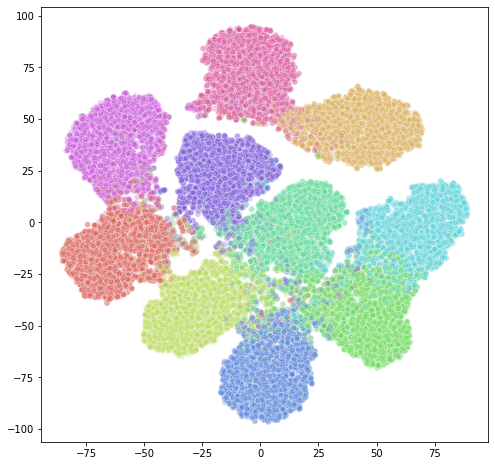

In [31]:
tsne_cifar10 = show_tsne(cifar10_x, cifar10_y, 10)

## 1. Cifar10 

## 1.1 Cifar10 with POP

Now try to run the algorithm POP


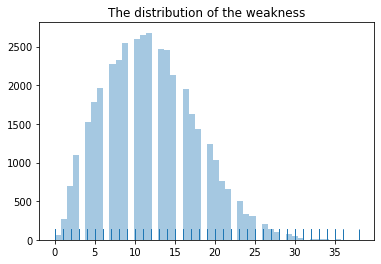

------------------ Start to select subsets ------------------


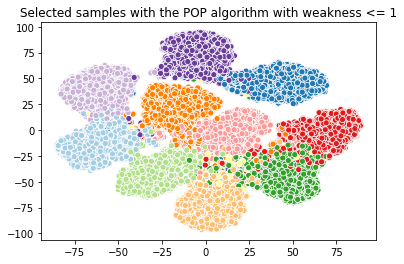

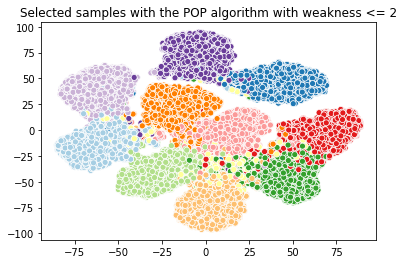

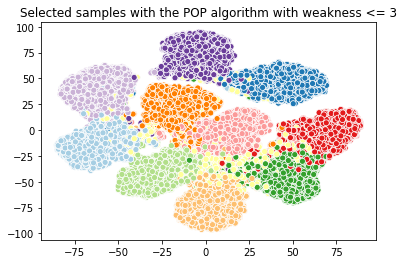

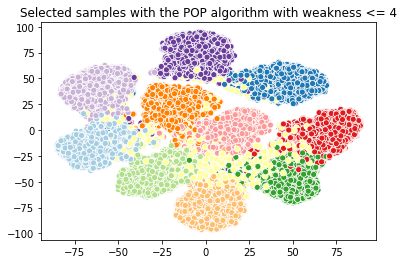

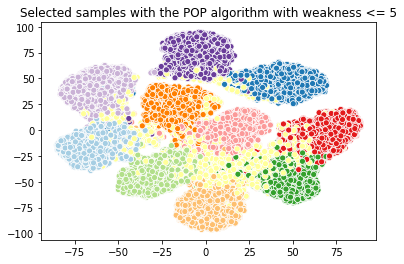

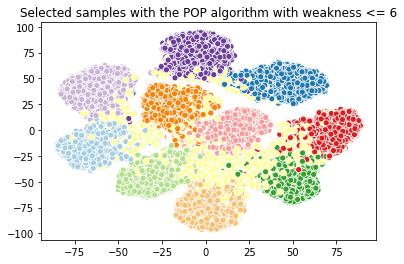

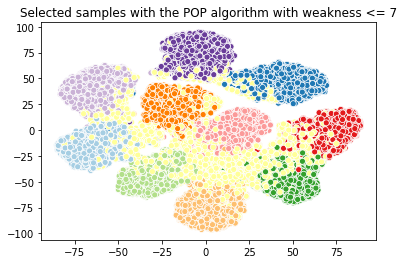

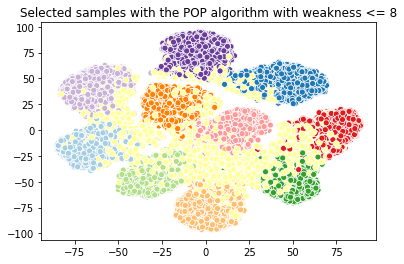

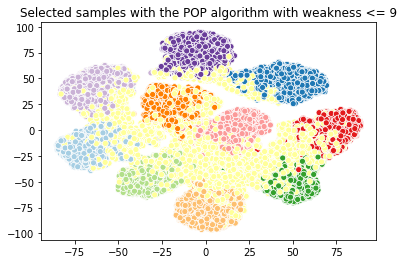

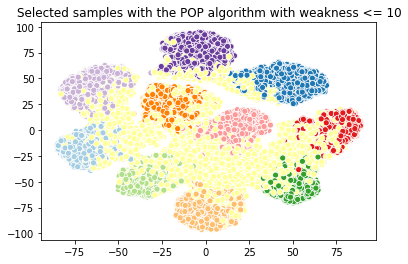

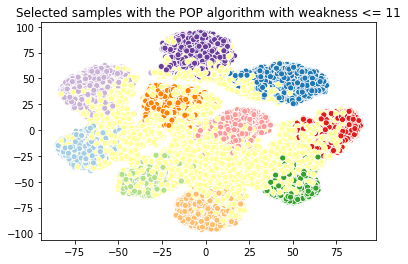

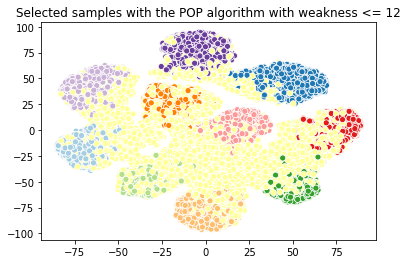

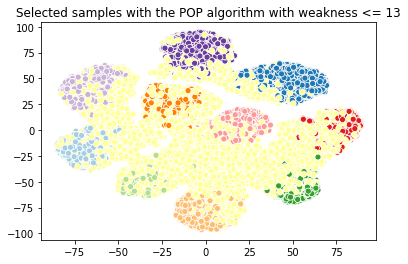

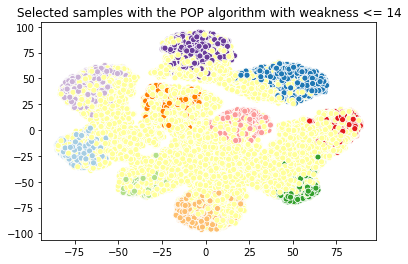

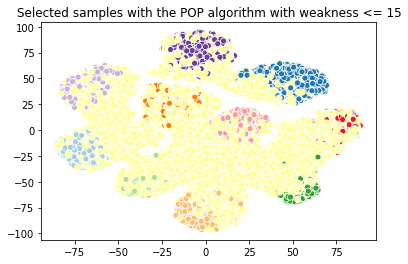

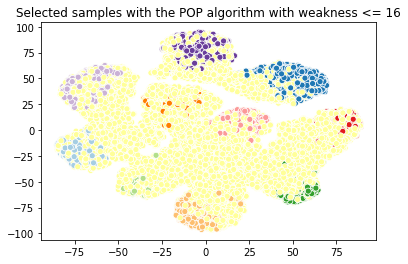

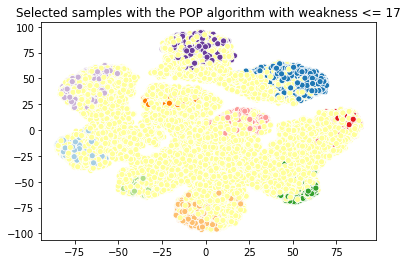

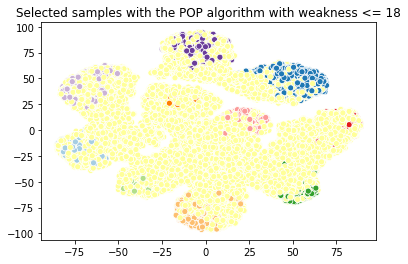

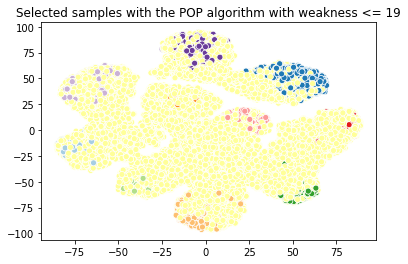

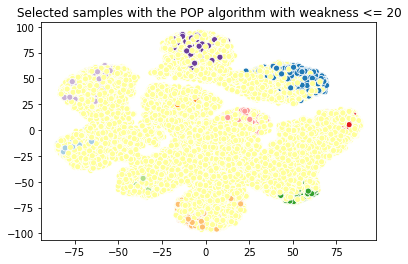

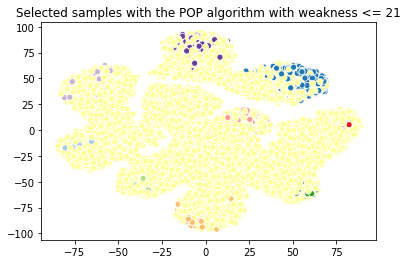

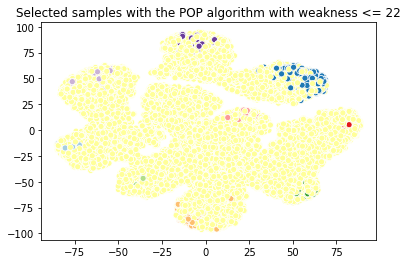

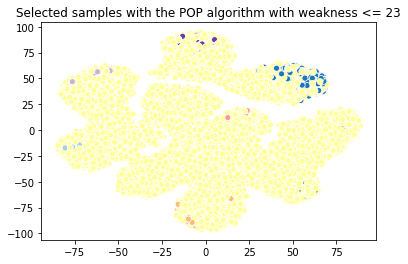

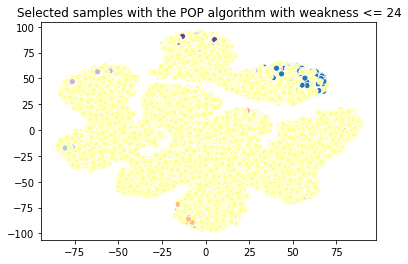

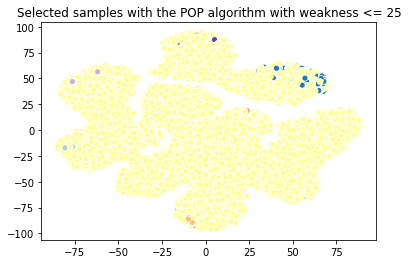

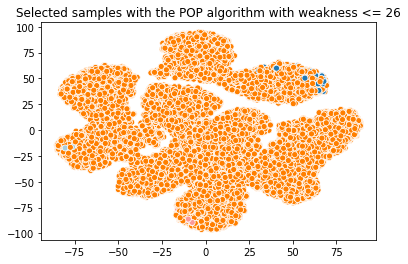

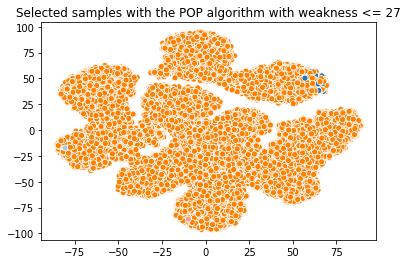

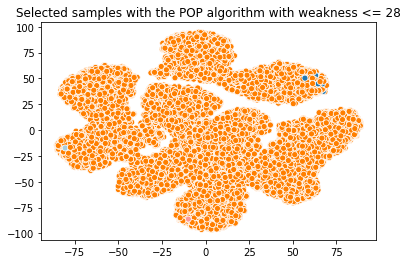

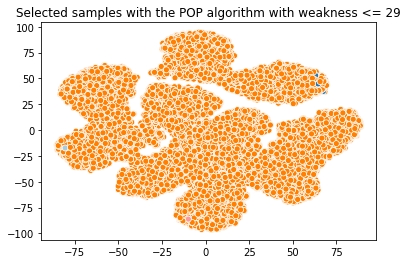

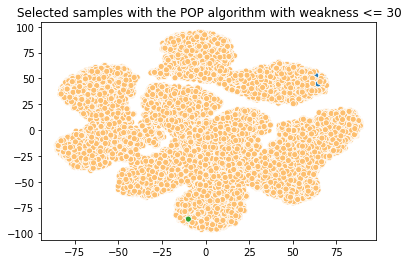

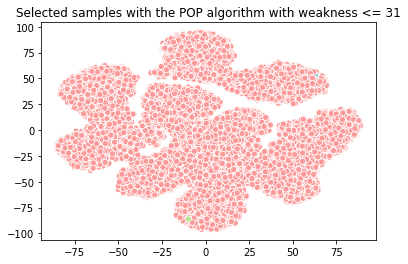

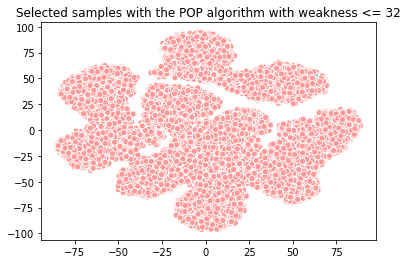

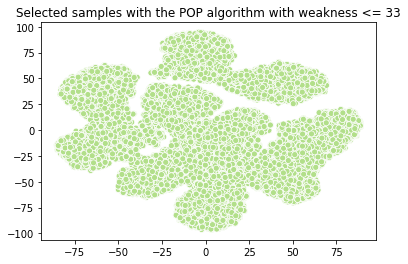

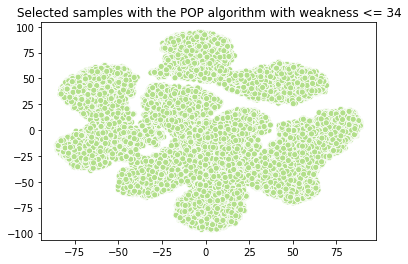

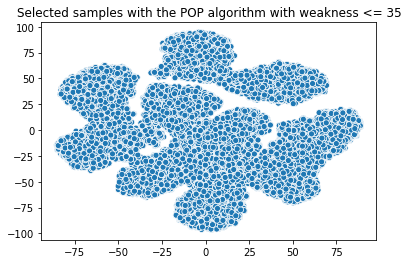

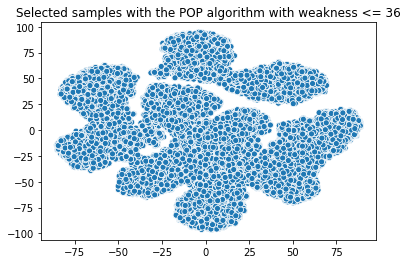

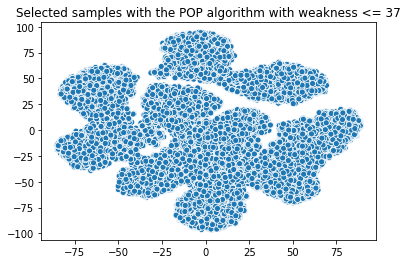

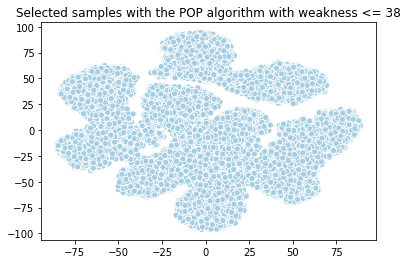

In [40]:
subsets = run_pop(cifar10_x, cifar10_y, 10, tsne_cifar10)

## 1.2 CIFAR10 with EGDIS

In [41]:
%load_ext memory_profiler

Now try to run the algorithm EGDIS with the generated sample dataset.
Selected 6506 samples


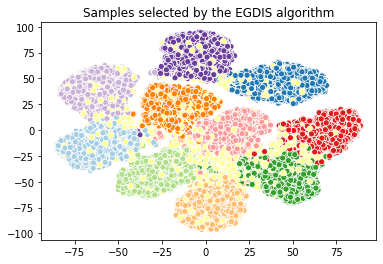

peak memory: 10083.94 MiB, increment: 9794.01 MiB
CPU times: user 19min 18s, sys: 3min 57s, total: 23min 15s
Wall time: 12min 32s


In [42]:
%time %memit selected_egdis_idx = run_egdis(cifar10_x, cifar10_y, 10, tsne_cifar10)

In [70]:
np.save(os.path.join(os.getcwd(),  "datasets", "cifar10", "selected_egdis_idx.npy"),selected_egdis_idx,allow_pickle=True)

## 1.3 CIFAR10 with CL

Now try to run the algorithm CL with CIFAR
------------------ Start to select subsets ------------------
Selected 10 percent training data.


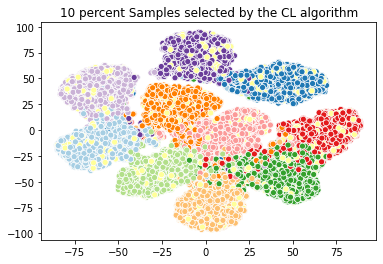

------------------ Start to select subsets ------------------
Selected 30 percent training data.


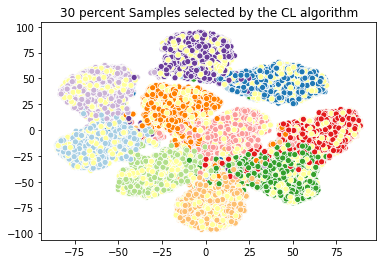

------------------ Start to select subsets ------------------
Selected 50 percent training data.


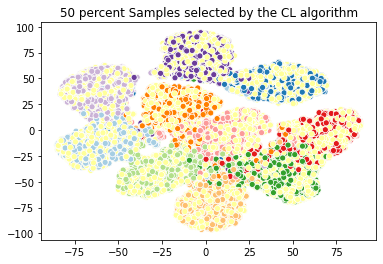

------------------ Start to select subsets ------------------
Selected 70 percent training data.


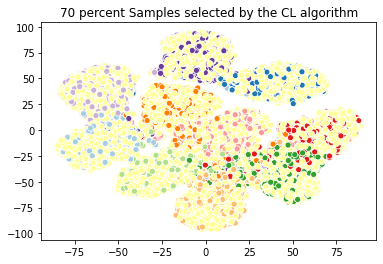

------------------ Start to select subsets ------------------
Selected 90 percent training data.


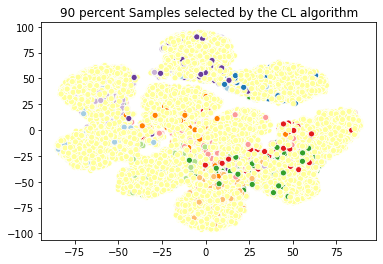

In [73]:
selected_list, scores = run_cl(cifar10_x, cifar10_y, 10, tsne_cifar10)

In [76]:
np.save(os.path.join(os.getcwd(),  "datasets", "cifar10", "cl_scores.npy"),scores,allow_pickle=True)

## 1.4 CIFAR with WCL

Now try to run the WCL algorithm CL with CIFAR
Selected 3069 boundary instances.


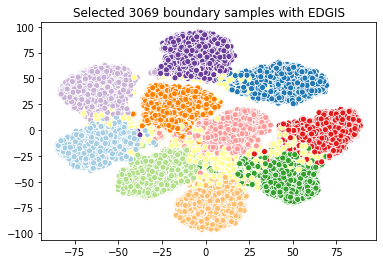

Select 10.00 percent samples, 92 overlapping with the pre-selected boundary samples
Select 30.00 percent samples, 359 overlapping with the pre-selected boundary samples
Select 50.00 percent samples, 634 overlapping with the pre-selected boundary samples
Select 70.00 percent samples, 1014 overlapping with the pre-selected boundary samples
Select 90.00 percent samples, 1659 overlapping with the pre-selected boundary samples
peak memory: 365.86 MiB, increment: 84.95 MiB
CPU times: user 1min 14s, sys: 611 ms, total: 1min 15s
Wall time: 12.7 s


In [78]:
%time %memit scores, selected_boundary_idx = run_wcl(cifar10_x, cifar10_y, 10, tsne_cifar10)

In [79]:
np.save(os.path.join(os.getcwd(),  "datasets", "cifar10", "cl_boundary_idx.npy"),selected_boundary_idx,allow_pickle=True)